In [ ]:
# Install necessary libraries
!pip install tensorflow



In [ ]:
%cd data
!unzip "/content/audio.zip"

/content/data
Archive:  /content/audio.zip
   creating: audio/
  inflating: audio/Dys_1.wav         
  inflating: audio/Dys_10.wav        
  inflating: audio/Dys_11.wav        
  inflating: audio/Dys_12.wav        
  inflating: audio/Dys_13.wav        
  inflating: audio/Dys_14.wav        
  inflating: audio/Dys_15.wav        
  inflating: audio/Dys_16.wav        
  inflating: audio/Dys_17.wav        
  inflating: audio/Dys_18.wav        
  inflating: audio/Dys_19.wav        
  inflating: audio/Dys_2.wav         
  inflating: audio/Dys_20.wav        
  inflating: audio/Dys_21.wav        
  inflating: audio/Dys_22.wav        
  inflating: audio/Dys_23.wav        
  inflating: audio/Dys_24.wav        
  inflating: audio/Dys_25.wav        
  inflating: audio/Dys_26.wav        
  inflating: audio/Dys_27.wav        
  inflating: audio/Dys_28.wav        
  inflating: audio/Dys_29.wav        
  inflating: audio/Dys_3.wav         
  inflating: audio/Dys_30.wav        
  inflating: audio/Dys_31

In [ ]:
%cd /content/

/content


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import librosa
import numpy as np

# Load and preprocess the audio data with padding
def load_and_preprocess_audio(file_path, target_length=16000):
    audio, _ = librosa.load(file_path, sr=16000)  # Adjust sr if your audio has a different sampling rate

    # Pad or truncate the audio sequence to the target length
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    else:
        audio = audio[:target_length]

    audio = audio.reshape(-1, 1)  # Convert to a 2D array
    return audio
# Generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64 * 16 * 128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 128, 64)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(16, 5, strides=2, padding='same', input_shape=(16000, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(32, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Add more layers as needed

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


# Define the generator and discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()


# Define loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

# Load audio files from a folder
def load_audio_files_from_folder(folder_path):
    audio_files = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            audio_files.append(file_path)
    return audio_files


# Specify the folder containing your audio files
folder_path = '/content/data/audio'

# Load audio file paths from the folder
audio_file_paths = load_audio_files_from_folder(folder_path)

# Batch size and noise dimension
BATCH_SIZE = len(audio_file_paths)
noise_dim = 100

# Prepare dataset with padding
target_length = 16000  # Adjust to your desired sequence length
padded_audio_data = [load_and_preprocess_audio(file_path, target_length=target_length) for file_path in audio_file_paths]
train_dataset = tf.data.Dataset.from_tensor_slices(padded_audio_data).shuffle(len(audio_file_paths)).batch(BATCH_SIZE)

# Train the model
train(train_dataset, epochs=50)

ValueError: in user code:

    File "<ipython-input-8-420ddadb63a9>", line 73, in train_step  *
        fake_output = discriminator(generated_images, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 16000, 1), found shape=(50, 32, 256, 1)


In [ ]:
!git clone https://github.com/mazzzystar/WaveGAN-pytorch.git

Cloning into 'WaveGAN-pytorch'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 62 (delta 7), reused 6 (delta 6), pack-reused 52
Receiving objects: 100% (62/62), 447.04 KiB | 4.66 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
%cd "/content/WaveGAN-pytorch"

/content/WaveGAN-pytorch


In [ ]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
  Created wheel for pescador: filename=pescador-2.1.0-py3-none-any.whl size=21088 sha256=965719b7d1dbc7c79dda55e4f5bbde3e886c48ebf6e0e29c331c0e8cc81dcfc6
  Stored in directory: /root/.cache/pip/wheels/f6/ad/f9/6130b2cd36727689c30c64be3cd41f8d98df8a8a224da9e19c
Successfully built pescador


In [ ]:
!pip install torch

In [ ]:
!python train.py

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pescador/zmq_stream.py", line 30, in <module>
    from joblib.parallel import SafeFunction
ImportError: cannot import name 'SafeFunction' from 'joblib.parallel' (/usr/local/lib/python3.10/dist-packages/joblib/parallel.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/WaveGAN-pytorch/train.py", line 5, in <module>
    from utils import save_samples
  File "/content/WaveGAN-pytorch/utils.py", line 9, in <module>
    import pescador
  File "/usr/local/lib/python3.10/dist-packages/pescador/__init__.py", line 8, in <module>
    from .zmq_stream import *
  File "/usr/local/lib/python3.10/dist-packages/pescador/zmq_stream.py", line 33, in <module>
    from joblib._parallel_backends import SafeFunction
ImportError: cannot import name 'SafeFunction' from 'joblib._parallel_backends' (/usr/local/lib/python3.10/dist-packages/joblib/_parallel

In [ ]:
%cd ..

/content


In [ ]:
!git clone https://github.com/Deepest-Project/MelNet.git

Cloning into 'MelNet'...
remote: Enumerating objects: 787, done.
remote: Total 787 (delta 0), reused 0 (delta 0), pack-reused 787
Receiving objects: 100% (787/787), 171.79 KiB | 4.52 MiB/s, done.
Resolving deltas: 100% (511/511), done.


In [ ]:
%cd /content/MelNet

/content/MelNet


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 700.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp310-cp310-linux_x86_64.whl size=73470 sha256=bc6514c81b0226649db3552044e3f7bf3fafd4de19dc8dea8fab0323a55dddc4
  Stored in directory: /root/.cache/pip/wheels/2a/2b/84/ac7bacfe8c68a87c1ee3dd3c66818a54c71599abf308e8eb35
Successfully built webrtcvad
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu12

In [ ]:
!pip install inflect

In [ ]:
!pip install torch==1.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.0 which is incomp

In [ ]:
!pip install jamo

In [ ]:
!python trainer.py -c ./config/kss.yaml -n my_experiment -t 6 -b 1


/content/MelNet/text/__init__.py:117: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/content/MelNet/text/__init__.py:117: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
2024-01-29 07:38:43.835424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 07:38:43.835735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 07:38:44.019763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 07:38:44.447604: I tensorflow/core/p

In [ ]:
!python trainer.py -c [config YAML file path] -n [name of run] -t [tier number] -b [batch size] -s [TTS]

####hugging fase model audio mimic

In [ ]:
!pip install speechbrain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 19.1 MB/s eta 0:00:00


In [ ]:
import torchaudio
from speechbrain.pretrained import WaveformEnhancement
run_opts={"device":"cuda"}
enhance_model = WaveformEnhancement.from_hparams(
    source="speechbrain/mtl-mimic-voicebank",
    savedir="pretrained_models/mtl-mimic-voicebank",
)
enhanced = enhance_model.enhance_file("speechbrain/mtl-mimic-voicebank/example.wav")

# Saving enhanced signal on disk
torchaudio.save('enhanced.wav', enhanced.unsqueeze(0).cpu(), 16000)


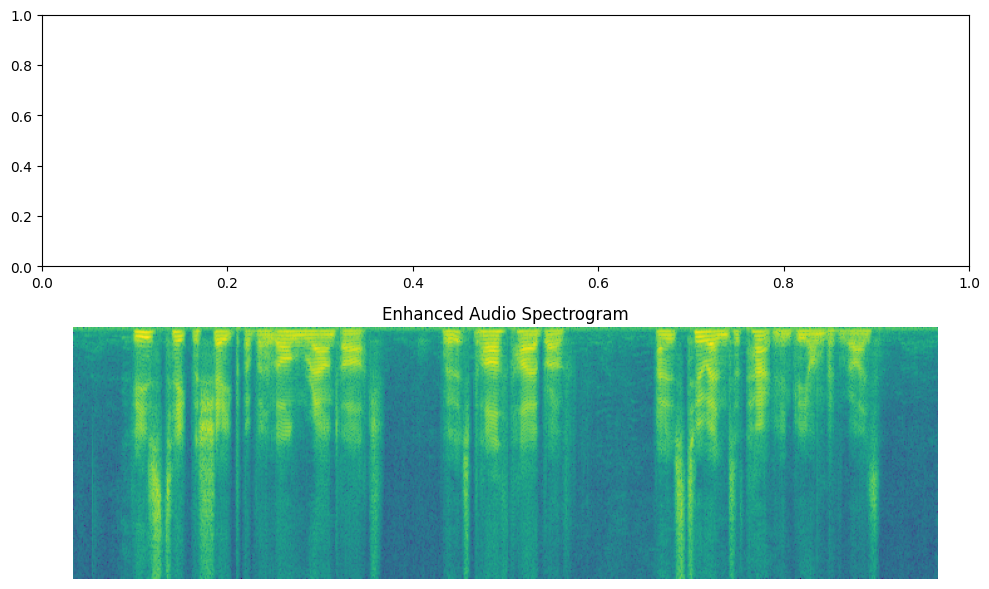

In [ ]:
import torchaudio
import matplotlib.pyplot as plt

# Load the original and enhanced audio files
# original_waveform, original_sample_rate = torchaudio.load("speechbrain/mtl-mimic-voicebank/example.wav")
enhanced_waveform, enhanced_sample_rate = torchaudio.load("enhanced.wav")

# Calculate spectrograms using torchaudio's Spectrogram function
# original_spectrogram = torchaudio.transforms.Spectrogram()(original_waveform)
enhanced_spectrogram = torchaudio.transforms.Spectrogram()(enhanced_waveform)

# Plot the spectrograms using matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# ax1.set_title("Original Audio Spectrogram")
# ax1.imshow(original_spectrogram.log2()[0, :, :].numpy(), cmap="viridis")
# ax1.axis("off")

ax2.set_title("Enhanced Audio Spectrogram")
ax2.imshow(enhanced_spectrogram.log2()[0, :, :].numpy(), cmap="viridis")
ax2.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torchaudio
from speechbrain.pretrained import WaveformEnhancement
run_opts={"device":"cuda"}
enhance_model = WaveformEnhancement.from_hparams(
    source="speechbrain/mtl-mimic-voicebank",
    savedir="pretrained_models/mtl-mimic-voicebank",
)
enhanced = enhance_model.enhance_file("/content/download.wav")

# Saving enhanced signal on disk
torchaudio.save('new.wav', enhanced.unsqueeze(0).cpu(), 16000)


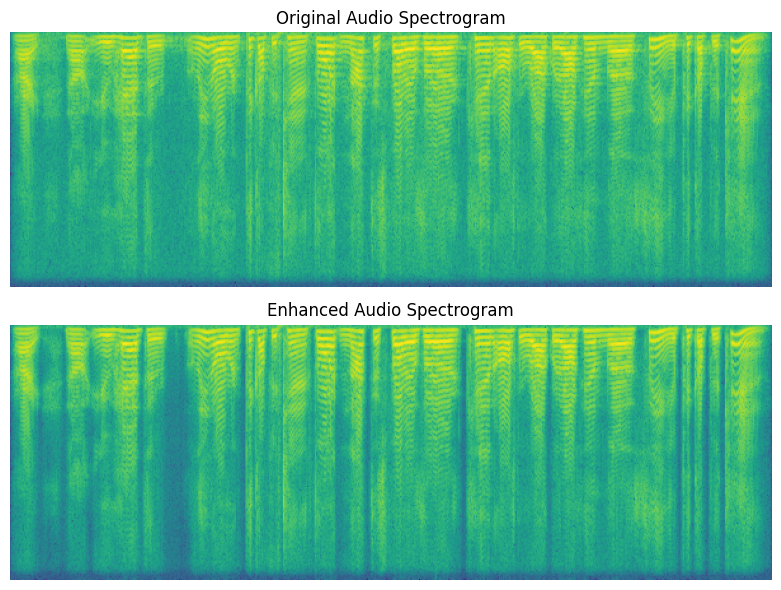

In [ ]:
import torchaudio
import matplotlib.pyplot as plt

# Load the original and enhanced audio files
original_waveform, original_sample_rate = torchaudio.load("/content/download.wav")
enhanced_waveform, enhanced_sample_rate = torchaudio.load("new.wav")

# Calculate spectrograms using torchaudio's Spectrogram function
original_spectrogram = torchaudio.transforms.Spectrogram()(original_waveform)
enhanced_spectrogram = torchaudio.transforms.Spectrogram()(enhanced_waveform)

# Plot the spectrograms using matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.set_title("Original Audio Spectrogram")
ax1.imshow(original_spectrogram.log2()[0, :, :].numpy(), cmap="viridis")
ax1.axis("off")

ax2.set_title("Enhanced Audio Spectrogram")
ax2.imshow(enhanced_spectrogram.log2()[0, :, :].numpy(), cmap="viridis")
ax2.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
%cd /content/
# the codebase has been tested on Python 3.8 / 3.10 with PyTorch 1.12.1 / 1.13 conda binaries
!git clone https://github.com/NVIDIA/BigVGAN


/content
Cloning into 'BigVGAN'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 59 (delta 19), reused 46 (delta 12), pack-reused 0
Receiving objects: 100% (59/59), 14.46 MiB | 6.74 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
pwd

'/content/wavegan'

In [ ]:
%cd /content/BigVGAN
!pip install -r requirements.txt

/content/BigVGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262920 sha256=32685fe170ee09ad9aaa1c0ecad309cc7aaac0137daf50d5c7aac1bcad5329ad
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq
  Attempting uninstall: librosa
    Found existing installation: librosa 0.6.2
    Uninstalling librosa-0.6.2:
      Successfully uninstalled librosa-0.6.2


In [ ]:
!python train.py \
--config configs/bigvgan_24khz_100band.json \
--input_wavs_dir /content/dataset/audio \
--checkpoint_path /content/drive/MyDrive/bigvgan_24khz_100band/

2024-01-29 11:47:32.517141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
Initializing Training Process..
Traceback (most recent call last):
  File "/content/BigVGAN/train.py", line 445, in <module>
    main()
  File "/content/BigVGAN/train.py", line 427, in main
    build_env(a.config, 'config.json', a.checkpoint_path)
  File "/content/BigVGAN/env.py", line 18, in build_env
    shutil.copyfile(config, os.path.join(path, config_name))
  File "/usr/lib/python3.10/shutil.py", line 256, in copyfile
    with open(dst, 'wb') as fdst:
PermissionError: [Errno 1] Operation not permitted: '/content/drive/MyDrive/bigvgan_24khz_100band/config.json'


In [ ]:
!python inference.py \
--checkpoint_file /content/drive/MyDrive/bigvgan_24khz_100band/g_05000000 \
--input_wavs_dir /content/sample \
--output_dir /content/generated

Initializing Inference Process..
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Loading '/content/drive/MyDrive/bigvgan_24khz_100band/g_05000000'
Complete.
Removing weight norm...
max value is  tensor(1.0071, device='cuda:0')
/content/generated/download_generated.wav


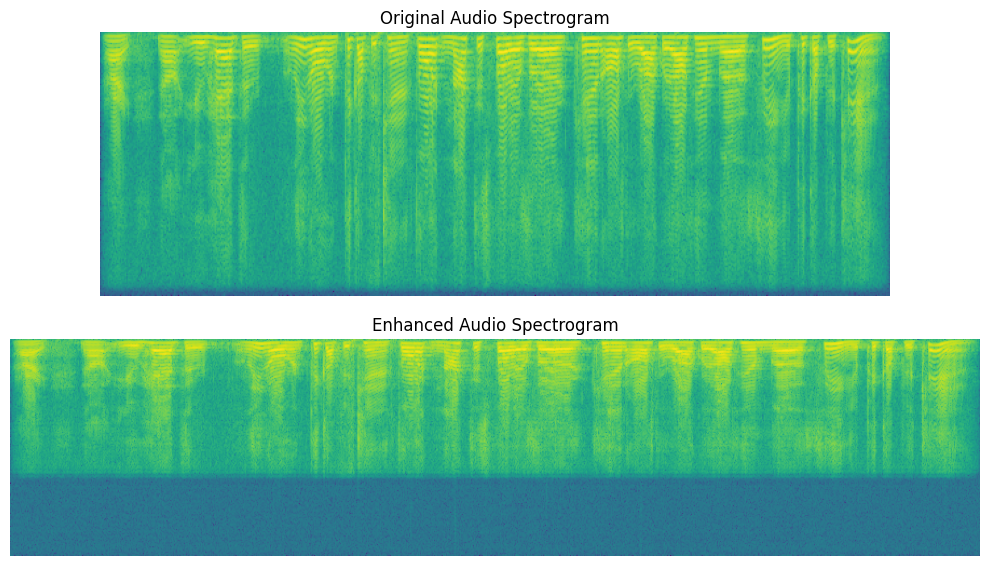

In [ ]:
import torchaudio
import matplotlib.pyplot as plt

# Load the original and enhanced audio files
original_waveform, original_sample_rate = torchaudio.load("/content/sample/download.wav")
enhanced_waveform, enhanced_sample_rate = torchaudio.load("/content/generated/download_generated.wav")

# Calculate spectrograms using torchaudio's Spectrogram function
original_spectrogram = torchaudio.transforms.Spectrogram()(original_waveform)
enhanced_spectrogram = torchaudio.transforms.Spectrogram()(enhanced_waveform)

# Plot the spectrograms using matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.set_title("Original Audio Spectrogram")
ax1.imshow(original_spectrogram.log2()[0, :, :].numpy(), cmap="viridis")
ax1.axis("off")

ax2.set_title("Enhanced Audio Spectrogram")
ax2.imshow(enhanced_spectrogram.log2()[0, :, :].numpy(), cmap="viridis")
ax2.axis("off")

plt.tight_layout()
plt.show()

#### wavagan

In [ ]:
!git  clone https://github.com/chrisdonahue/wavegan

Cloning into 'wavegan'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 562 (delta 66), reused 62 (delta 62), pack-reused 488
Receiving objects: 100% (562/562), 74.27 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [ ]:
!pip install tensorflow-gpu==2.8.0
!pip install scipy==1.0.0
!pip install matplotlib==3.0.2
!pip install librosa==0.6.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 69.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.9 MB/s eta 0:00:00
  Created wheel for librosa: filename=librosa-0.6.2-py3-none-any.whl size=1569672 sha256=dd6b2016b8c22e0e31d379bf566d03377f12635b1651c23df4697044abf0171c
  Stored in directory: /root/.cache/pip/wheels/ab/ee/5a/3d8acd9c4441f53b56c3b19e2c2e3f351439fd4e8310b31f7d
Successfully built librosa
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.1
    Uninstalling librosa-0.10.1:
      Successfully uninstalled librosa-0.10.1


In [ ]:
!pip install tensorflow==1.15


ERROR: Could not find a version that satisfies the requirement tensorflow==1.15 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==1.15


In [ ]:
%cd /content/wavegan

/content/wavegan


In [ ]:
# CHANGE THIS to use a different dataset
dataset = 'speech' # one of 'digits', 'speech', 'birds', 'drums', 'piano'

# Confirm GPU is running
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
if len(get_available_gpus()) == 0:
  for i in range(4):
    print('WARNING: Not running on a GPU! See above for faster generation')

# Download model
if dataset == 'digits':
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/sc09_infer.meta -O infer.meta
elif dataset == 'speech':
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/timit_infer.meta -O infer.meta
elif dataset == 'birds':
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/birds_infer.meta -O infer.meta
elif dataset == 'drums':
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/drums_infer.meta -O infer.meta
elif dataset == 'piano':
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano.ckpt.index -O model.ckpt.index
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano.ckpt.data-00000-of-00001 -O model.ckpt.data-00000-of-00001
  !wget https://s3.amazonaws.com/wavegan-v1/models/piano_infer.meta -O infer.meta
else:
  raise NotImplementedError()

# Load the model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
saver = tf.compat.v1.train.import_meta_graph('infer.meta')
graph = tf.compat.v1.get_default_graph()
sess = tf.compat.v1.InteractiveSession()
saver.restore(sess, 'model.ckpt')

--2024-01-29 11:04:32--  https://s3.amazonaws.com/wavegan-v1/models/timit.ckpt.index
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.87.238, 52.217.225.224, 52.217.102.126, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.87.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 733 [binary/octet-stream]
Saving to: ‘model.ckpt.index’

model.ckpt.index    100%[===================>]     733  --.-KB/s    in 0s      

2024-01-29 11:04:32 (77.1 MB/s) - ‘model.ckpt.index’ saved [733/733]

--2024-01-29 11:04:32--  https://s3.amazonaws.com/wavegan-v1/models/timit.ckpt.data-00000-of-00001
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.87.238, 52.217.225.224, 52.217.102.126, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.87.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76263436 (73M) [application/x-www-form-urlencoded]
Saving to: ‘model.ckpt.data-00000-of-00001’

model.ckpt.data-000 100%[===========

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
!pip install tensorflow==2.8.0

In [ ]:
%cd /content/dataset/
!unzip /content/audio.zip
%cd wavegan

/content/dataset
Archive:  /content/audio.zip
   creating: audio/
  inflating: audio/Dys_1.wav         
  inflating: audio/Dys_10.wav        
  inflating: audio/Dys_11.wav        
  inflating: audio/Dys_12.wav        
  inflating: audio/Dys_13.wav        
  inflating: audio/Dys_14.wav        
  inflating: audio/Dys_15.wav        
  inflating: audio/Dys_16.wav        
  inflating: audio/Dys_17.wav        
  inflating: audio/Dys_18.wav        
  inflating: audio/Dys_19.wav        
  inflating: audio/Dys_2.wav         
  inflating: audio/Dys_20.wav        
  inflating: audio/Dys_21.wav        
  inflating: audio/Dys_22.wav        
  inflating: audio/Dys_23.wav        
  inflating: audio/Dys_24.wav        
  inflating: audio/Dys_25.wav        
  inflating: audio/Dys_26.wav        
  inflating: audio/Dys_27.wav        
  inflating: audio/Dys_28.wav        
  inflating: audio/Dys_29.wav        
  inflating: audio/Dys_3.wav         
  inflating: audio/Dys_30.wav        
  inflating: audio/Dys

In [ ]:
%cd /content/wavegan

/content/wavegan


Finished! (Took 9.974177122116089 seconds)
--------------------------------------------------------------------------------
Example 0


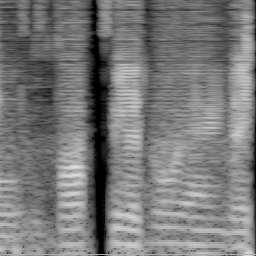

--------------------------------------------------------------------------------
Example 1


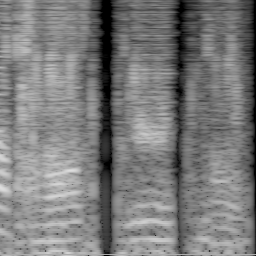

--------------------------------------------------------------------------------
Example 2


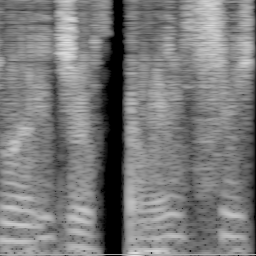

--------------------------------------------------------------------------------
Example 3


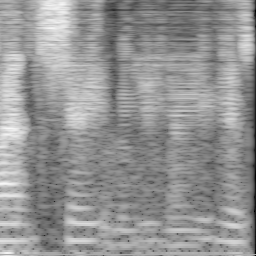

In [ ]:
# Generate and display audio

# CHANGE THESE to change number of examples generated/displayed
ngenerate = 64
ndisplay = 4

import numpy as np
import PIL.Image
from IPython.display import display, Audio
import time as time

# Sample latent vectors
_z = (np.random.rand(ngenerate, 100) * 2.) - 1.

# Generate
z = graph.get_tensor_by_name('z:0')
G_z = graph.get_tensor_by_name('G_z:0')[:, :, 0]
G_z_spec = graph.get_tensor_by_name('G_z_spec:0')

start = time.time()
_G_z, _G_z_spec = sess.run([G_z, G_z_spec], {z: _z})
print('Finished! (Took {} seconds)'.format(time.time() - start))

for i in range(ndisplay):
  print('-' * 80)
  print('Example {}'.format(i))
  display(PIL.Image.fromarray(_G_z_spec[i]))
  display(Audio(_G_z[i], rate=16000))

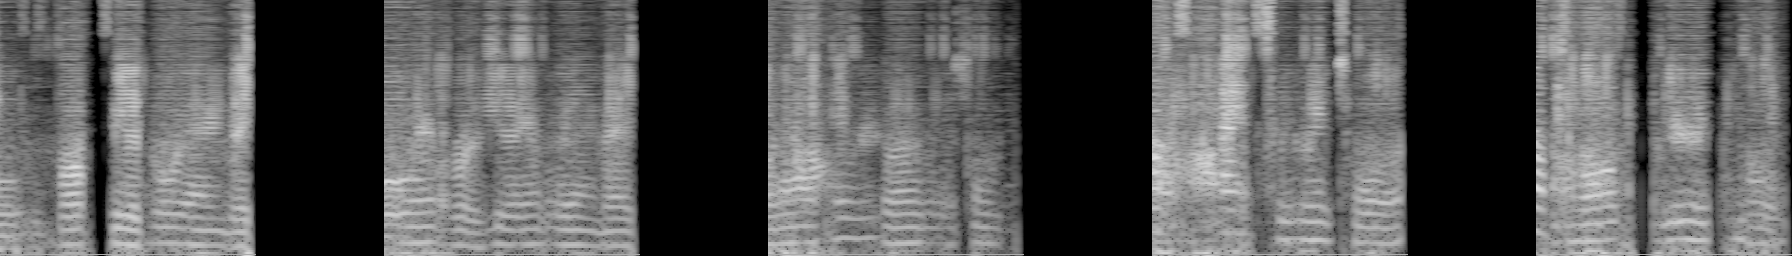

In [ ]:
# Interpolate in latent space

# CHANGE THESE to example IDs from the above cell
interp_a = 0
interp_b = 1

# CHANGE THIS to change number of intermediates
interp_n = 3

# Interpolate latent codes
_za, _zb = _z[interp_a], _z[interp_b]
_z_interp = []
for i in range(interp_n + 2):
  a = i / float(interp_n + 1)
  _z_interp.append((1-a) * _za + a * _zb)

# Concatenate for easier visualization
flat_pad = graph.get_tensor_by_name('flat_pad:0')
G_z_flat = graph.get_tensor_by_name('G_z_flat:0')[:, 0]
G_z_spec_padded = tf.pad(G_z_spec, [[0, 0], [0, 0], [0, 128]])
G_z_spec_padded = tf.transpose(G_z_spec_padded, [0, 2, 1])
G_z_spec_flat = tf.reshape(G_z_spec_padded, [-1, 256])
G_z_spec_flat = tf.transpose(G_z_spec_flat, [1, 0])[:, :-128]

# Generate
_G_z_flat, _G_z_spec = sess.run([G_z_flat, G_z_spec_flat], {z: _z_interp, flat_pad: 8192})

# Display
display(PIL.Image.fromarray(_G_z_spec))
display(Audio(_G_z_flat, rate=16000))

In [ ]:
!export CUDA_VISIBLE_DEVICES="0"
!python train_wavegan.py train ./train \
	--data_dir /content/dataset/audio \
	--data_first_slice \
	--data_pad_end \
	--data_fast_wav

2024-01-29 11:13:06.472137: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
Found 50 audio files in specified directory
Traceback (most recent call last):
  File "/content/wavegan/train_wavegan.py", line 653, in <module>
    infer(args)
  File "/content/wavegan/train_wavegan.py", line 244, in infer
    samp_z_n = tf.compat.v1.placeholder(tf.int32, [], name='samp_z_n')
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/array_ops.py", line 3298, in placeholder
    raise RuntimeError("tf.placeholder() is not compatible with "
RuntimeError: tf.placeholder() is not compatible with eager execution.


#### COQUI TTS

In [ ]:
!pip install TTS

In [ ]:
!git clone https://github.com/coqui-ai/TTS
!pip install -e .[all,dev,notebooks]  # Select the relevant extras
!make system-deps  # intended to be used on Ubuntu (Debian). Let us know if you have a different OS.
!make install

Cloning into 'TTS'...
remote: Enumerating objects: 32839, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 32839 (delta 19), reused 26 (delta 16), pack-reused 32804
Receiving objects: 100% (32839/32839), 166.21 MiB | 27.18 MiB/s, done.
Resolving deltas: 100% (23811/23811), done.
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
%cd TTS
!pip install -e .[all,dev,notebooks]  # Select the relevant extras


/content/TTS
Obtaining file:///content/TTS
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.7/205.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.6/392.6 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.4/32.4 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.6/581.6 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47

In [ ]:
import TTS
# Init TTS with the target model name
tts = TTS(model_name="tts_models/de/thorsten/tacotron2-DDC", progress_bar=False).to(device)

# Run TTS
tts.tts_to_file(text="Ich bin eine Testnachricht.", file_path=OUTPUT_PATH)

# Example voice cloning with YourTTS in English, French and Portuguese
tts = TTS(model_name="tts_models/multilingual/multi-dataset/your_tts", progress_bar=False).to(device)
tts.tts_to_file("This is voice cloning.", speaker_wav="/content/download.wav", language="en", file_path="output.wav")
tts.tts_to_file("C'est le clonage de la voix.", speaker_wav="/content/download.wav", language="fr-fr", file_path="output.wav")
tts.tts_to_file("Isso é clonagem de voz.", speaker_wav="/content/download.wav", language="pt-br", file_path="output.wav")

TypeError: 'module' object is not callable